# Лабораторная работа 5

# Сети с радиальными базисными элементами

### Тимофеев А. В., М8О-407Б-19

Цель работы: исследование свойств сетей Хопфилда, Хэмминга и Элмана, алгоритмов обучения, а также применение сетей в задачах распознавания статических и динамических
образов.

Вариант 12

In [92]:
import torch
import matplotlib.pyplot as plt
import numpy as np 
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from collections import defaultdict
from tqdm import tqdm
import time
from timeit import default_timer as timer
import random

### Cеть Элмана

In [93]:
class Elman(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Elman, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.w1 = nn.Parameter(torch.randn(self.input_dim, self.output_dim))
        self.w2 = nn.Parameter(torch.randn(self.output_dim, self.output_dim))
        self.b = nn.Parameter(torch.randn(self.output_dim))
        self.prev = torch.zeros(self.output_dim)

    def clear_memory(self):
        self.prev = torch.zeros(self.output_dim)

    def forward(self, input):
        d = torch.matmul(self.prev, self.w2)
        out = torch.matmul(input, self.w1)
        out = torch.add(out, d)
        out = torch.add(out, self.b)
        out = torch.tanh(out)
        self.prev = torch.tensor(out)
        return out



In [94]:
def g1(x):
    return np.sin(4 * np.pi * x)

def g2(x):
    return np.sin(np.sin(x)*x**2 + 5*x)

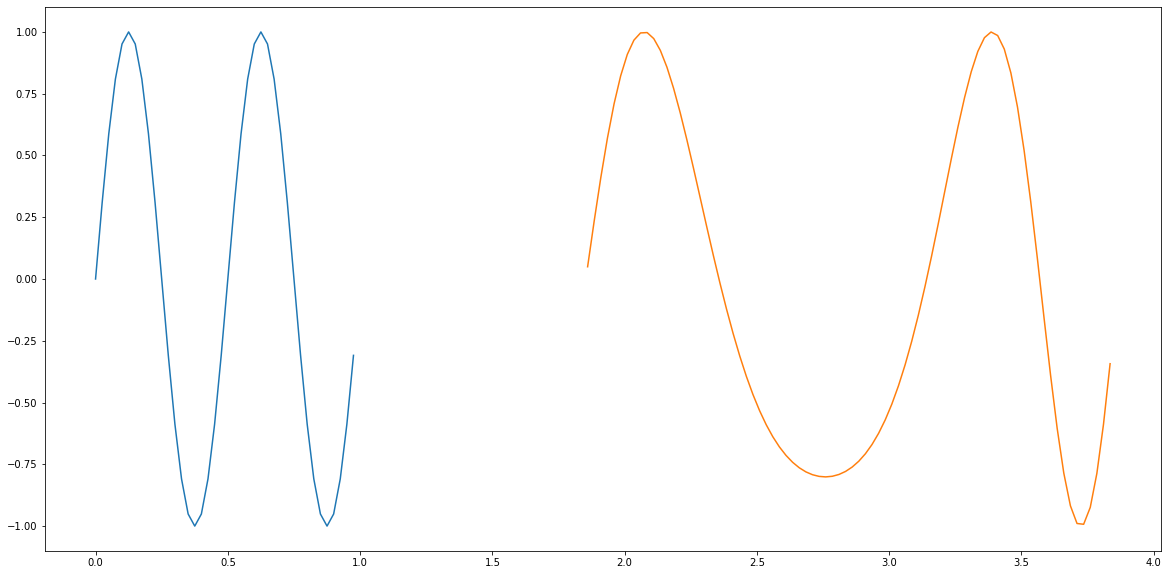

In [95]:
t1 = np.arange(0, 1, 0.025)
t2 = np.arange(1.86, 3.86, 0.025)

figure = plt.figure(figsize = (20, 10))

plt.plot(t1, g1(t1))
plt.plot(t2, g2(t2))
plt.show()

In [96]:
def make_signal(r1 = 4, r2 = 3, r3 = 0):
    signal = np.concatenate((np.tile(g1(t1), r1), g2(t2), np.tile(g1(t1), r2), g2(t2), np.tile(g1(t1), r3), g2(t2)), axis = 0, dtype = np.float32)
    labels = np.concatenate((np.full((len(t1) * r1,), -1), np.ones((len(t2),)), np.full((len(t1)*r2,), -1), np.ones((len(t2),)),  np.full((len(t1) * r3,), -1), np.ones((len(t2),))), axis = 0, dtype = np.float32)

    return signal, labels

def get_train_data(signal, labels, window = 1):
    signal_seq = [np.array(signal[i:i+window], dtype = np.float32) for i in range(0, len(signal) - window)]
    labels_seq = [np.array(labels[i:i+window], dtype = np.float32) for i in range(0, len(labels) - window)]
    output = [(x,y) for x, y in zip(signal_seq, labels_seq)]
    return output

0it [00:00, ?it/s]<ipython-input-93-de6d9bd05f10>:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prev = torch.tensor(out)
512it [00:00, 1418.28it/s]
512it [00:00, 1395.10it/s]
512it [00:00, 1406.59it/s]
512it [00:00, 1426.10it/s]
512it [00:00, 1414.36it/s]
512it [00:00, 1414.48it/s]
512it [00:00, 1450.33it/s]
512it [00:00, 1430.18it/s]
512it [00:00, 1418.28it/s]
512it [00:00, 1406.60it/s]
512it [00:00, 1395.09it/s]
512it [00:00, 1426.19it/s]
512it [00:00, 1422.21it/s]
512it [00:00, 1422.11it/s]
512it [00:00, 1365.23it/s]
512it [00:00, 1380.16it/s]
512it [00:00, 1376.35it/s]
512it [00:00, 1383.78it/s]
512it [00:00, 1383.79it/s]
512it [00:00, 1414.37it/s]
512it [00:00, 1406.59it/s]
512it [00:00, 1402.63it/s]
512it [00:00, 1410.47it/s]
512it [00:00, 1434.18it/s]
512it [00:00, 1398.90it/s]
512it [00:00, 1426.18it/s]
512it [00:00, 14

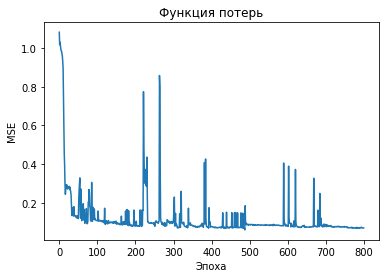

In [97]:
epochs = 800
window = 8

elman = Elman(input_dim=window, output_dim=8)
linear = nn.Linear(in_features=8, out_features=window)

model = nn.Sequential(elman, linear)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

signal, labels = make_signal(r1=4, r2=3, r3=0)
train_dataset = get_train_data(signal, labels, window=window)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=1, shuffle = False)
model.train()

train_loss = []

for i in range(epochs):

    pbar = tqdm(enumerate(train_loader))

    elman.clear_memory()
    last_loss = []
    for j, (input, output_gt) in pbar:
        output = model(input)
        crit = nn.MSELoss()
        loss = torch.sqrt(crit(output_gt, output))
        last_loss += [loss.item()]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss += [np.mean(last_loss)]

model.eval()

elman.clear_memory()

predict = []

for x, y in train_dataset:
    predict += [model(torch.tensor(x)).detach().numpy().item(0)]

predict = np.array(predict)
predict[predict > 0] = 1
predict[predict < 0] = -1

plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('MSE')
plt.plot(train_loss)
plt.show()



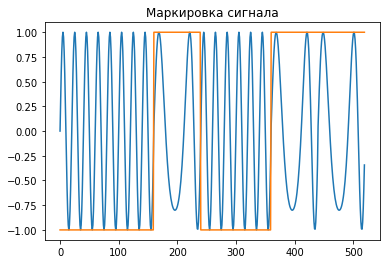

In [98]:
plt.title('Маркировка сигнала')
plt.plot(signal)
plt.plot(labels)


plt.show()

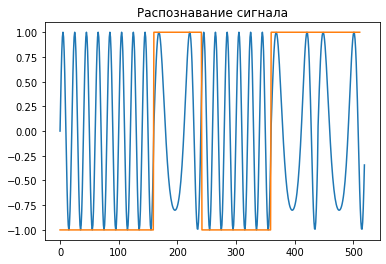

In [99]:
plt.title('Распознавание сигнала')
plt.plot(signal)
plt.plot(predict)

plt.show()

### Сеть Хопфилда

In [100]:
from PIL import Image

def load_image(path, width=320, height=240):
    image = Image.open(path)
    image = image.convert('RGB')  # удалить альфа канал, иногда он может присутствовать!
    image = image.resize((width, height), Image.ANTIALIAS)
    image = np.asarray(image, dtype=np.float32)
    image = np.dot(image[..., :3], [0.2989, 0.5870, 0.1140]).astype(np.float32)  # получить float32 вместо double
    image = (image - 127.5) / 127.5  # нормализовать [-1..1]
    return image.flatten()

In [101]:
class Hopfield(nn.Module):
    def __init__(self, input_dim):
        super(Hopfield, self).__init__()
        self.w = nn.Parameter(torch.zeros(input_dim, input_dim))
        self.b = nn.Parameter(torch.zeros(input_dim))
        self.prev = torch.zeros(input_dim)
        
    def set_initial_value(self, value):
        self.prev = value.detach().clone()
        
    def forward(self, input = 0):
        out = torch.matmul(self.prev, self.w)
        out = torch.add(out, self.b)
        out = torch.clamp(out, min = -1, max = 1)
        self.prev = out.detach().clone()
        return out

In [102]:
width = 10
height = 12

def load_images():
    return [
        load_image('img/six.png', width, height),
        load_image('img/one.png', width, height),
        load_image('img/two.png', width, height),
    ]

def load_images7():
    return [
        load_image('img/seven.png', width, height),
        load_image('img/five.png', width, height)
    ]

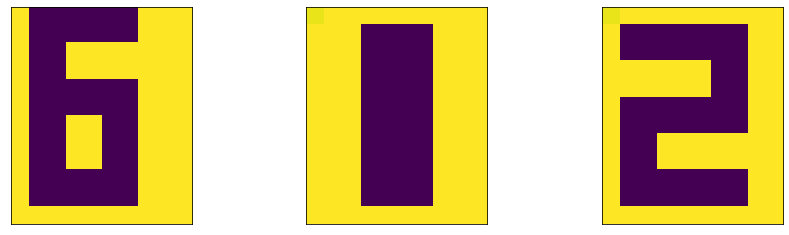

In [103]:
images = load_images()
images7 = load_images7()
traindl = DataLoader(images, batch_size = 1, shuffle = True)

fig = plt.figure(figsize = (len(images) * 5, 4))
for i, img in enumerate(images):
    ax = fig.add_subplot(1, len(images), i + 1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(img.reshape(12, 10))
plt.show()

In [104]:
hopfield = Hopfield(120)

epochs = 500
optim = torch.optim.Adam(hopfield.parameters(), lr = 1e-4)
history = defaultdict(list)
hopfield.train()

for epoch in range(epochs):
    for img in traindl:
        losses = []
        hopfield.set_initial_value(img)
        out = hopfield()
        loss = nn.MSELoss()(out, img)

        optim.zero_grad()
        loss.backward()
        optim.step()

        losses.append(loss.item())

        history['loss'].append(np.mean(losses))

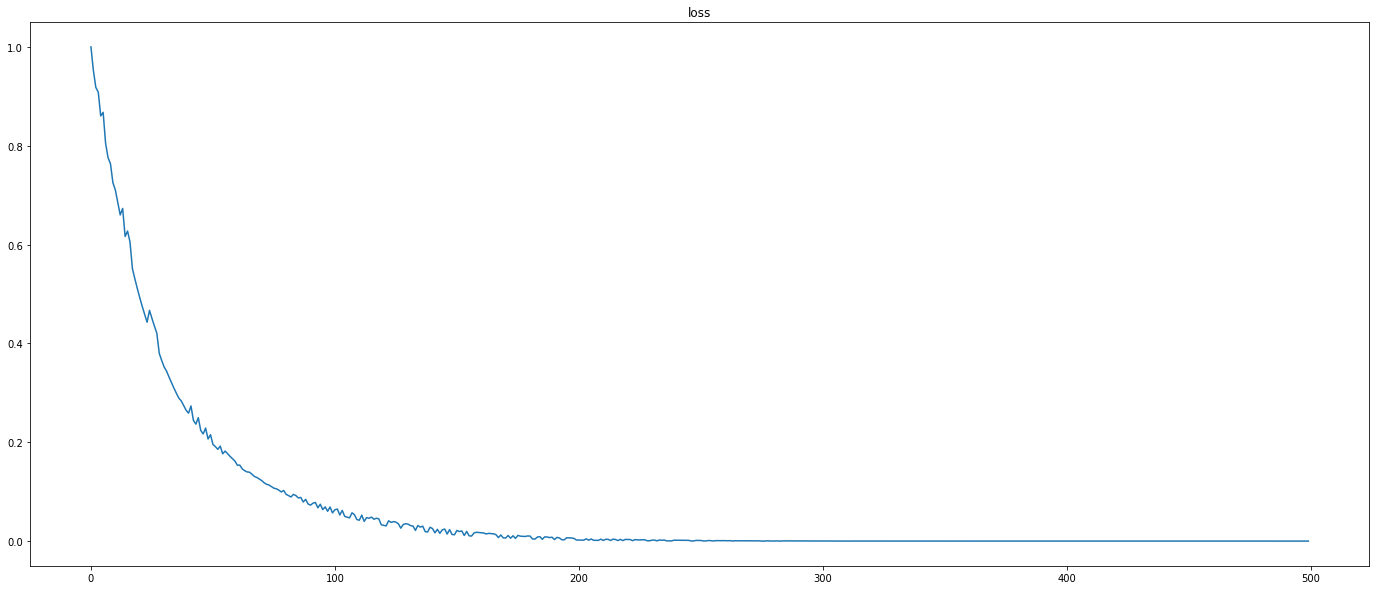

In [105]:
tt = np.arange(0, epochs, 1)

figure = plt.figure(figsize = (24, 10))

# hist1 = history['loss'][1:]
# hist2 = history['loss'][2:]

plt.title('loss')
plt.plot(tt, history['loss'][::3])

plt.show()

Проверим сеть на данном в задании датасете.

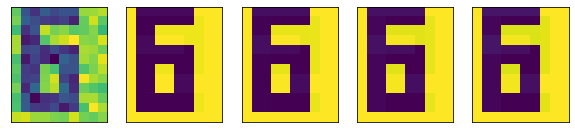

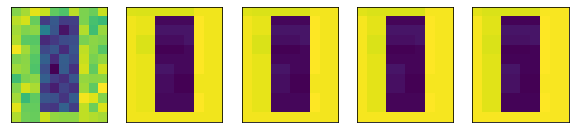

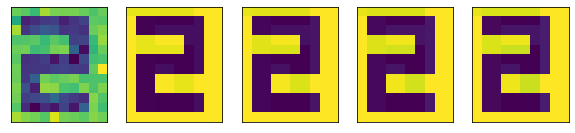

In [106]:
for img in images:
    out = torch.clamp(torch.tensor(img) + torch.randn(img.shape) / 4, -2, 2) / 2

    hopfield.eval()
    hopfield.set_initial_value(out)
    steps = 5
    fig = plt.figure(figsize=(steps * 2, 4))
    for i in range(steps):
        ax = fig.add_subplot(1, steps, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(out.detach().numpy().reshape(12, 10))
        out = hopfield()
    plt.show()


Проверим работу сети на цифрах не данных в задании.

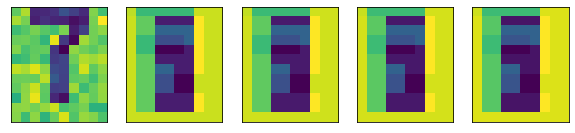

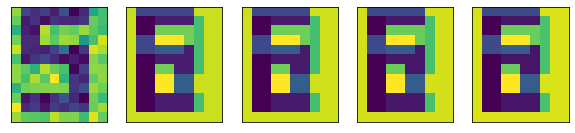

In [107]:

for img in images7:
    out = torch.clamp(torch.tensor(img) + torch.randn(img.shape) / 4, -2, 2) / 2

    hopfield.eval()
    hopfield.set_initial_value(out)
    steps = 5
    fig = plt.figure(figsize=(steps * 2, 4))
    for i in range(steps):
        ax = fig.add_subplot(1, steps, i+1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.imshow(out.detach().numpy().reshape(12, 10))
        out = hopfield()
    plt.show()


### Выводы

В ходе выполнения лабораторной работы я познакомился рекуррентными сетями. За
счет использования информации о предыдущем состоянии, рекуррентные сети могут
распознавать сложные динамические образы силами одного линейного слоя или использоваться в качестве автоассоциативной памяти. Однако такие сети значительно
сложнее в настройке и обучении.